Na dnešních cvičeních se podíváme na dva algoritmy z oblasti rojové inteligence - optimalizaci pomocí kolonií mravenců (Ant Colony Optimization) a pomocí hejn částic (Particle Swarm Optimization).

Oba algoritmy jsou relativně snadné na implementaci a proto je napíšeme od začátku.

## Ant Colony Optimization

ACO algoritmus se hodí především pro kombinatorickou optimalizaci, konkrétně na problémy, které se dají převést na hledání cest v grafu. Jako příklad si pomocí ACO vyřešíme problém obchodního cestujícího, tedy problém hledání nejkratší Hamiltonovské kružnice v úplném grafu.

In [106]:
from collections import namedtuple
import math
import functools

import numpy as np

Vertex = namedtuple('Vertex', ['name', 'x', 'y'])

# hlavni kod ACO
def ant_solver(vertices, distance):
    P = initialize_pheromone(len(vertices))
    best_sol = None
    best_fit = float('inf')
    for it in range(1000):
        sols = list(generate_solutions(vertices, P, distance, 100))
        fits = list(map(lambda x: fitness(vertices, distance, x), sols))
        P = update_pheromone(P, sols, fits)
        
        for s, f in zip(sols, fits):
            if f < best_fit:
                best_fit = f
                best_sol = s
        
        print(it, best_fit)
    return best_sol, P

# vypocet vzdalenosti
@functools.lru_cache(maxsize=None)
def distance(v1, v2):
    return math.sqrt((v1.x - v2.x)**2+(v1.y - v2.y)**2)

# vypocet fitness
def fitness(vertices, dist, sol):
    sd = 0
    for x, y in zip(sol, sol[1:]):
        sd += dist(vertices[x], vertices[y])
    sd += dist(vertices[sol[-1]], vertices[sol[0]])
    return sd

# pocatecni inicializace feromonu
def initialize_pheromone(N):
    return 0.01*np.ones(shape=(N,N))

# vytvoreni reseni
def generate_solutions(vertices, P, dist, N, alpha=1, beta=3):
    
    # pravdepodobnost vyberu hrany (bez skalovani)
    def compute_prob(v1, v2):
        nu = 1/dist(vertices[v1], vertices[v2])
        tau = P[v1, v2]
        ret = pow(tau, alpha) * pow(nu,beta)
        return ret if ret > 0.000001 else 0.000001

    V = P.shape[0]
    for i in range(N):
        available = list(range(V))
        sol = [np.random.randint(0, V)]
        available.remove(sol[0])
        while available:
            probs = np.array(list(map(lambda x: compute_prob(sol[-1], x), available)))
            selected = np.random.choice(available, p=probs/sum(probs)) # vyber hrany
            sol.append(selected)
            available.remove(selected)
        yield sol

def update_pheromone(P, sols, fits, Q=1, rho=0.7):
    ph_update = np.zeros(shape=P.shape)
    for s, f in zip(sols, fits):
        for x, y in zip(s, s[1:]):
            ph_update[x][y] += Q/f
        ph_update[s[-1]][s[0]] += Q/f
    
    return (1-rho)*P + ph_update        

In [107]:
import csv

# otestujeme algoritmus na evropskych hlavnich mestech
vertices = []
with open('cities.csv') as cities_file:
    csv_reader = csv.reader(cities_file, delimiter=',')
    for row in csv_reader:
        vertices.append(Vertex(row[0], float(row[2]), float(row[1])))

print(vertices)        

sol = list(range(len(vertices)))
print(fitness(vertices, distance, sol))

s, P = ant_solver(vertices, distance)

[Vertex(name='Tirana', x=19.81666667, y=41.31666667), Vertex(name='Andorra la Vella', x=1.5, y=42.5), Vertex(name='Vienna', x=16.36666667, y=48.21666667), Vertex(name='Minsk', x=27.55, y=53.9), Vertex(name='Brussels', x=4.316666667, y=50.81666667), Vertex(name='Sarajevo', x=18.36666667, y=43.85), Vertex(name='Sofia', x=23.3, y=42.68333333), Vertex(name='Zagreb', x=15.96666667, y=45.8), Vertex(name='Nicosia', x=33.36666667, y=35.15), Vertex(name='Prague', x=14.41666667, y=50.06666667), Vertex(name='Copenhagen', x=12.56666667, y=55.66666667), Vertex(name='Tallinn', x=24.73333333, y=59.43333333), Vertex(name='Helsinki', x=24.93333333, y=60.16666667), Vertex(name='Paris', x=2.333333333, y=48.85), Vertex(name='Berlin', x=13.36666667, y=52.51666667), Vertex(name='Athens', x=23.71666667, y=37.96666667), Vertex(name='Budapest', x=19.06666667, y=47.5), Vertex(name='Reykjavik', x=-21.91666667, y=64.13333333), Vertex(name='Dublin', x=-6.25, y=53.31666667), Vertex(name='Rome', x=12.5, y=41.8833333

270 227.80986367852856
271 227.80986367852856
272 227.80986367852856
273 227.80986367852856
274 227.80986367852856
275 227.80986367852856
276 227.80986367852856
277 227.80986367852856
278 227.80986367852856
279 227.80986367852856
280 227.80986367852856
281 227.80986367852856
282 227.80986367852856
283 227.80986367852856
284 227.80986367852856
285 227.80986367852856
286 227.80986367852856
287 227.80986367852856
288 227.80986367852856
289 227.80986367852856
290 227.80986367852856
291 227.80986367852856
292 227.80986367852856
293 227.80986367852856
294 227.80986367852856
295 227.80986367852856
296 227.80986367852856
297 227.80986367852856
298 227.80986367852856
299 227.80986367852856
300 227.80986367852856
301 227.80986367852856
302 227.80986367852856
303 227.80986367852856
304 227.80986367852856
305 227.80986367852856
306 227.80986367852856
307 227.80986367852856
308 227.80986367852856
309 227.80986367852856
310 227.80986367852856
311 227.80986367852856
312 227.80986367852856
313 227.809

627 227.80986367852856
628 227.80986367852856
629 227.80986367852856
630 227.80986367852856
631 227.80986367852856
632 227.80986367852856
633 227.80986367852856
634 227.80986367852856
635 227.80986367852856
636 227.80986367852856
637 227.80986367852856
638 227.80986367852856
639 227.80986367852856
640 227.80986367852856
641 227.80986367852856
642 227.80986367852856
643 227.80986367852856
644 227.80986367852856
645 227.80986367852856
646 227.80986367852856
647 227.80986367852856
648 227.80986367852856
649 227.80986367852856
650 227.80986367852856
651 227.80986367852856
652 227.80986367852856
653 227.80986367852856
654 227.80986367852856
655 227.80986367852856
656 227.80986367852856
657 227.80986367852856
658 227.80986367852856
659 227.80986367852856
660 227.80986367852856
661 227.80986367852856
662 227.80986367852856
663 227.80986367852856
664 227.80986367852856
665 227.80986367852856
666 227.80986367852856
667 227.80986367852856
668 227.80986367852856
669 227.80986367852856
670 227.809

989 227.80986367852856
990 227.80986367852856
991 227.80986367852856
992 227.80986367852856
993 227.80986367852856
994 227.80986367852856
995 227.80986367852856
996 227.80986367852856
997 227.80986367852856
998 227.80986367852856
999 227.80986367852856


[[(19.81666667, 41.31666667), (19.81666667, 41.31666667)], [(19.81666667, 41.31666667), (1.5, 42.5)], [(19.81666667, 41.31666667), (16.36666667, 48.21666667)], [(19.81666667, 41.31666667), (27.55, 53.9)], [(19.81666667, 41.31666667), (4.316666667, 50.81666667)], [(19.81666667, 41.31666667), (18.36666667, 43.85)], [(19.81666667, 41.31666667), (23.3, 42.68333333)], [(19.81666667, 41.31666667), (15.96666667, 45.8)], [(19.81666667, 41.31666667), (33.36666667, 35.15)], [(19.81666667, 41.31666667), (14.41666667, 50.06666667)]]


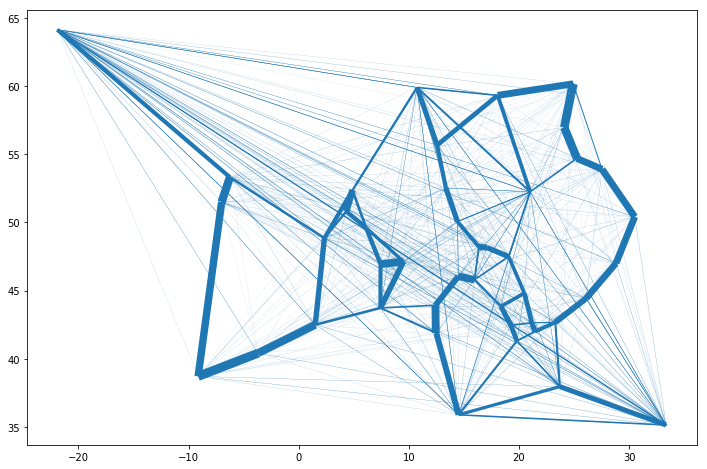

In [108]:
import matplotlib.pyplot as plt
from matplotlib import collections as mc

lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(v1.x, v1.y), (v2.x, v2.y)])
        colors.append(P[i][j])

        
lc = mc.LineCollection(lines, linewidths=20*np.array(colors))

print(lines[:10])

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

sol_lines = []
for i, j in zip(sol, sol[1:]):
    sol_lines.append([(vertices[i].x, vertices[i].y), (vertices[j].x, vertices[j].y)])

sol_lines.append([(vertices[sol[-1]].x, vertices[sol[-1]].y), (vertices[sol[0]].x, vertices[sol[0]].y)])

sols_lc = mc.LineCollection(sol_lines, colors='red')
#ax.add_collection(sols_lc)

## Optimalizace hejnem částic

Algoritmus optimalizace hejnem částic je velmi jednoduchý na implementaci. 

In [ ]:
class Partinamedtuple    
    def __init__(x, v):
        self.x = x
        self.v = v
        self.p_best = p_best